# module05_indexing


## precision_problem.py
precision_problem.py
Explanation of Precision Problem
In vector databases and similarity search, precision refers to the accuracy of retrieval.
Approximate indexing methods trade some precision for speed.
The precision problem occurs when the approximate results differ significantly from exact results.
This is a fundamental trade-off in large-scale similarity search.
Import required libraries for precision analysis
numpy for numerical operations and random number generation


In [19]:
import numpy as np
# cosine_similarity for measuring vector similarity
from sklearn.metrics.pairwise import cosine_similarity


In [20]:
# Exact k-nearest neighbor search using brute force approach
def exact_search(query, vectors, k=5):
    """
    Exact k-nearest neighbor search using brute force.
    This calculates similarity to ALL vectors and returns the top-k most similar.
    Time complexity: O(n) where n is the number of vectors.
    """
    # Calculate cosine similarity between query and all vectors
    similarities = cosine_similarity([query], vectors)[0]
    # Get indices of top-k most similar vectors (highest similarity first)
    top_k_indices = np.argsort(similarities)[::-1][:k]
    # Return list of (index, similarity) tuples
    return [(idx, similarities[idx]) for idx in top_k_indices]


In [21]:
# Simulate approximate search with controlled error to demonstrate precision issues
def approximate_search(query, vectors, k=5, error_rate=0.1):
    """
    Simulate approximate search with some error.
    This represents what happens with indexing methods like HNSW, IVF, or LSH.
    They don't check all vectors, leading to potential misses or ranking errors.
    """
    # Get more candidates than needed (simulating broader search in indexing)
    exact_results = exact_search(query, vectors, k=k*2)  # Get more candidates

    # Introduce approximation error by adding noise to similarities
    approximate_results = []
    for idx, sim in exact_results[:k]:
        # Add Gaussian noise to simulate indexing approximation errors
        noise = np.random.normal(0, error_rate)
        # Clamp result to [0,1] range (cosine similarity bounds)
        approx_sim = max(0, min(1, sim + noise))  # Keep in [0,1]
        approximate_results.append((idx, approx_sim))

    # Re-sort after introducing approximation errors
    approximate_results.sort(key=lambda x: x[1], reverse=True)
    # Return top-k approximate results
    return approximate_results[:k]

Real-world precision characteristics of different indexing methods:
- HNSW: High precision (>0.95) with good speed - best overall trade-off
- IVF: Good precision with coarse quantization - scales well to large datasets
- LSH: Lower precision but very fast - good for high-throughput scenarios
- Trade-offs depend on use case (real-time search vs. accuracy-critical applications)


Strategies for mitigating precision problems in production:
- Use higher-quality indexing parameters (more clusters, larger hash tables)
- Implement re-ranking: get more candidates from index, then re-rank exactly
- Hybrid approaches: combine multiple indexing methods for better coverage
- Regular precision monitoring and tuning based on your specific data distribution


## indexing_algorithms.py
indexing_algorithms.py
Explanation of Indexing Algorithms
Hierarchical Navigable Small World (HNSW) is a graph-based indexing algorithm.
It creates a multi-layer graph structure for efficient nearest neighbor search.
HNSW is widely used in production vector databases for its speed-accuracy balance.
Import required libraries for HNSW demonstration
numpy for vector operations and array handling


In [22]:
import numpy as np
# cosine_similarity for measuring vector similarity
from sklearn.metrics.pairwise import cosine_similarity
# heapq for priority queue operations (though not used in this simplified version)
import heapq


In [23]:
# Simplified HNSW implementation for educational purposes
# Real HNSW is much more complex with multiple layers and sophisticated algorithms
class SimpleHNSW:
    # Initialize HNSW structure with maximum connections per node
    def __init__(self, max_connections=16):
        # List to store all vectors in the index
        self.vectors = []
        # Graph structure: each index contains list of connected neighbor indices
        self.graph = []  # List of neighbor lists
        # Maximum number of connections per node (controls graph density)
        self.max_connections = max_connections

    # Add a vector to the HNSW structure
    def add_vector(self, vector):
        """
        Add a vector to the HNSW structure.
        In real HNSW, this involves probabilistic insertion into multiple layers.
        """
        # Convert input to numpy array for consistent handling
        vector = np.array(vector)
        # Add vector to the storage
        self.vectors.append(vector)
        # Get the index of the newly added vector
        idx = len(self.vectors) - 1
        # Initialize empty neighbor list for this vector
        self.graph.append([])

        # Only create connections if we have more than one vector
        if len(self.vectors) > 1:
            # Find nearest neighbors to connect with (simplified approach)
            neighbors = self._find_nearest_neighbors(vector, k=self.max_connections)
            # Store neighbors for this vector
            self.graph[idx] = neighbors

            # Add bidirectional connections (undirected graph)
            for neighbor_idx in neighbors:
                # Only add if not already connected (avoid duplicates)
                if idx not in self.graph[neighbor_idx]:
                    self.graph[neighbor_idx].append(idx)

    # Helper method to find nearest neighbors (simplified brute force for demo)
    def _find_nearest_neighbors(self, query, k):
        """
        Simple nearest neighbor search (brute force for demonstration).
        Real HNSW uses hierarchical graph traversal for efficiency.
        """
        # Return empty list if no vectors exist yet
        if not self.vectors:
            return []

        # Calculate similarity to all existing vectors except the one being added
        similarities = cosine_similarity([query], self.vectors[:-1])[0]  # Exclude self
        # Get indices of top-k most similar vectors
        top_k_indices = np.argsort(similarities)[::-1][:k]
        # Convert to list for easier handling
        return top_k_indices.tolist()

    # Search method to find k nearest neighbors to a query vector
    def search(self, query, k=5):
        """
        Search for k nearest neighbors.
        In real HNSW, this uses hierarchical navigation for efficiency.
        """
        # Return empty if no vectors in index
        if not self.vectors:
            return []

        # Convert query to numpy array
        query = np.array(query)
        # Calculate similarity to all vectors in the index
        similarities = cosine_similarity([query], self.vectors)[0]
        # Get top-k most similar vectors
        top_k_indices = np.argsort(similarities)[::-1][:k]

        # Build results with detailed information
        results = []
        for idx in top_k_indices:
            results.append({
                'index': idx,                    # Index in the vectors list
                'vector': self.vectors[idx],     # The actual vector
                'similarity': similarities[idx]  # Similarity score
            })

        # Return the k most similar vectors
        return results

In [24]:
# Example usage demonstrating HNSW indexing
# Create HNSW index instance
hnsw = SimpleHNSW()


In [25]:
# Define sample vectors representing different concepts
# These are 3D vectors for simplicity; real embeddings are much higher dimensional
vectors = [
    [1, 0, 0],      # Vector pointing strongly in x-direction
    [0, 1, 0],      # Vector pointing strongly in y-direction
    [0, 0, 1],      # Vector pointing strongly in z-direction
    [0.5, 0.5, 0],  # Vector in xy-plane
    [0, 0.5, 0.5],  # Vector in yz-plane
    [0.5, 0, 0.5]   # Vector in xz-plane
]


In [26]:
# Add all vectors to the HNSW index
for vec in vectors:
    hnsw.add_vector(vec)


In [27]:
# Perform search with a query vector
query = [0.6, 0.4, 0]  # Query vector similar to [0.5, 0.5, 0]
results = hnsw.search(query, k=3)


In [28]:
# Display search results
print("HNSW Search Results:")
for result in results:
    print(f"Similarity: {result['similarity']:.3f}, Vector: {result['vector']}")


HNSW Search Results:
Similarity: 0.981, Vector: [0.5 0.5 0. ]
Similarity: 0.832, Vector: [1 0 0]
Similarity: 0.588, Vector: [0.5 0.  0.5]


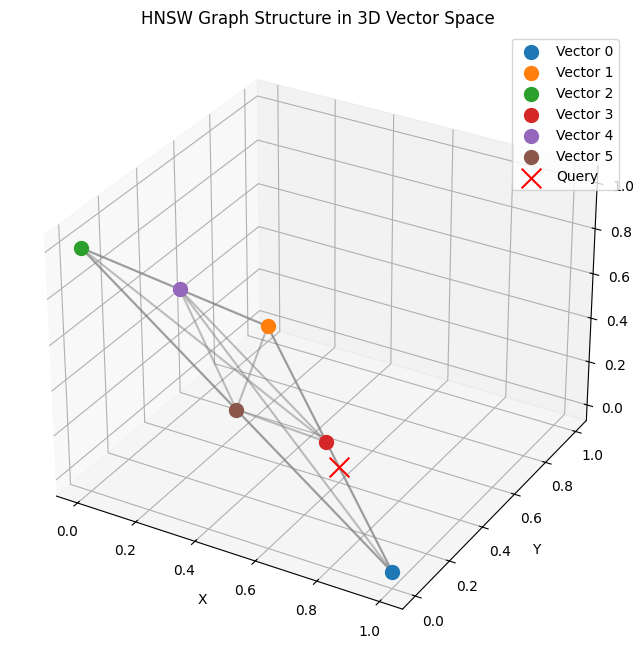

In [29]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Visualize HNSW: plot vectors in 3D and show some connections
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot all vectors
for i, vec in enumerate(vectors):
    ax.scatter(vec[0], vec[1], vec[2], s=100, label=f'Vector {i}')

# Plot some connections (simplified - in real HNSW there are many more)
for i in range(len(hnsw.graph)):
    for j in hnsw.graph[i]:
        if i < j:  # Avoid duplicate lines
            ax.plot([vectors[i][0], vectors[j][0]],
                   [vectors[i][1], vectors[j][1]],
                   [vectors[i][2], vectors[j][2]], 'gray', alpha=0.5)

# Plot query
ax.scatter(query[0], query[1], query[2], color='red', s=200, marker='x', label='Query')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('HNSW Graph Structure in 3D Vector Space')
ax.legend()
plt.show()

Key characteristics of HNSW algorithm:
- Multi-layer graph structure: Different layers for coarse and fine search
- Hierarchical navigation: Start from top layer, drill down to find neighbors
- Probabilistic construction: Random decisions for graph connectivity
- Excellent search quality vs. speed trade-off: Fast and accurate


Other important indexing approaches used in vector databases:
- IVF (Inverted File): Partition vector space into clusters, search within relevant clusters
- LSH (Locality Sensitive Hashing): Hash similar vectors to same buckets for quick lookup


## indexing_approaches.py
indexing_approaches.py
Explanation of Indexing Approaches
Different strategies for organizing and searching high-dimensional vector data.
Each approach has different trade-offs between speed, accuracy, and memory usage.
Import required libraries for indexing demonstrations
numpy for numerical operations and vector handling


In [30]:
import numpy as np
# KMeans for clustering in IVF implementation
from sklearn.cluster import KMeans
# cosine_similarity for measuring vector similarity
from sklearn.metrics.pairwise import cosine_similarity


In [31]:
# Inverted File (IVF) - Partition-based approach
# IVF divides vector space into clusters and searches only relevant clusters
class SimpleIVF:
    # Initialize IVF with number of clusters to create
    def __init__(self, n_clusters=10):
        # Number of clusters (partitions) to divide the space into
        self.n_clusters = n_clusters
        # K-means model for clustering (initialized during build_index)
        self.kmeans = None
        # List of lists: each sublist contains vector indices belonging to that cluster
        self.clusters = [[] for _ in range(n_clusters)]
        # Storage for all vectors in the index
        self.vectors = []

    # Build the IVF index by clustering all vectors
    def build_index(self, vectors):
        """
        Build IVF index by clustering vectors.
        This creates partitions that group similar vectors together.
        """
        # Convert all vectors to numpy arrays for consistent handling
        self.vectors = [np.array(v) for v in vectors]
        # Convert to numpy array for sklearn compatibility
        vectors_array = np.array(vectors)

        # Use K-means clustering to partition the vector space
        self.kmeans = KMeans(n_clusters=self.n_clusters, random_state=42)
        # Fit K-means and get cluster assignments for each vector
        cluster_labels = self.kmeans.fit_predict(vectors_array)

        # Assign each vector to its corresponding cluster
        for idx, label in enumerate(cluster_labels):
            self.clusters[label].append(idx)

    # Search using IVF approach: find nearest clusters, then search within them
    def search(self, query, k=5):
        """
        Search using IVF: query nearest clusters first.
        This avoids searching the entire dataset by focusing on relevant partitions.
        """
        # Convert query to numpy array
        query = np.array(query)

        # Find distances to all cluster centers
        cluster_distances = cosine_similarity([query], self.kmeans.cluster_centers_)[0]
        # Get indices of the 3 nearest clusters (can be tuned)
        nearest_cluster_indices = np.argsort(cluster_distances)[::-1][:3]  # Top 3 clusters

        # Collect candidate vectors from the nearest clusters
        candidates = []
        for cluster_idx in nearest_cluster_indices:
            # For each vector in this cluster, calculate similarity to query
            for vec_idx in self.clusters[cluster_idx]:
                similarity = cosine_similarity([query], [self.vectors[vec_idx]])[0][0]
                candidates.append((vec_idx, similarity))

        # Sort candidates by similarity (highest first) and return top-k
        candidates.sort(key=lambda x: x[1], reverse=True)
        return candidates[:k]

In [32]:
# Locality Sensitive Hashing (LSH) - Hash-based approach
# LSH hashes similar vectors to the same buckets for efficient lookup
import hashlib


In [33]:
class SimpleLSH:
    # Initialize LSH with multiple hash tables for better accuracy
    def __init__(self, num_hash_tables=5, hash_size=8):
        # Number of hash tables (more tables = better accuracy but more memory)
        self.num_hash_tables = num_hash_tables
        # Size of hash values (affects collision probability)
        self.hash_size = hash_size
        # List of hash tables (dictionaries mapping hash values to vector indices)
        self.hash_tables = [{} for _ in range(num_hash_tables)]
        # Storage for all vectors
        self.vectors = []

    # Hash function that converts vector to an integer hash value
    def _hash_vector(self, vector, seed):
        """
        Simple hash function for vector (not cryptographically secure).
        Uses MD5 hash of vector string representation with seed for different tables.
        """
        # Convert vector to string with fixed precision
        vec_str = ','.join(f"{x:.6f}" for x in vector)
        # Create hash with seed to get different hashes for different tables
        hash_obj = hashlib.md5(f"{vec_str}_{seed}".encode())
        # Convert hex hash to integer and take modulo for fixed-size hash
        return int(hash_obj.hexdigest(), 16) % (2 ** self.hash_size)

    # Add vector to LSH index by hashing it into multiple tables
    def add_vector(self, vector):
        """
        Add vector to LSH index.
        Each vector is hashed into multiple hash tables for redundancy.
        """
        # Convert to numpy array
        vector = np.array(vector)
        # Store the vector
        self.vectors.append(vector)
        # Get index of newly added vector
        idx = len(self.vectors) - 1

        # Hash the vector into each hash table
        for table_idx in range(self.num_hash_tables):
            # Generate hash value for this table
            hash_value = self._hash_vector(vector, table_idx)
            # Initialize bucket if it doesn't exist
            if hash_value not in self.hash_tables[table_idx]:
                self.hash_tables[table_idx][hash_value] = []
            # Add vector index to the hash bucket
            self.hash_tables[table_idx][hash_value].append(idx)

    # Search using LSH: find vectors that hash to same buckets as query
    def search(self, query, k=5):
        """
        Search using LSH: find vectors in same hash buckets.
        This is probabilistic - may miss some similar vectors but is very fast.
        """
        # Convert query to numpy array
        query = np.array(query)
        # Set to collect candidate vector indices (eliminates duplicates)
        candidates = set()

        # Query each hash table to find potential similar vectors
        for table_idx in range(self.num_hash_tables):
            # Get hash value for query in this table
            hash_value = self._hash_vector(query, table_idx)
            # If hash bucket exists, add all vectors in it to candidates
            if hash_value in self.hash_tables[table_idx]:
                candidates.update(self.hash_tables[table_idx][hash_value])

        # Calculate actual similarities for all candidate vectors
        results = []
        for idx in candidates:
            similarity = cosine_similarity([query], [self.vectors[idx]])[0][0]
            results.append((idx, similarity))

        # Sort by similarity and return top-k results
        results.sort(key=lambda x: x[1], reverse=True)
        return results[:k]

In [34]:
# Example usage demonstrating both IVF and LSH approaches
vectors = [
    [1, 0, 0],      # Vector along x-axis
    [0, 1, 0],      # Vector along y-axis
    [0, 0, 1],      # Vector along z-axis
    [0.5, 0.5, 0],  # Vector in xy-plane
    [0, 0.5, 0.5],  # Vector in yz-plane
    [0.5, 0, 0.5]   # Vector in xz-plane
]


In [35]:
# Demonstrate IVF (Inverted File) indexing
ivf = SimpleIVF(n_clusters=3)  # Use 3 clusters for this small dataset
ivf.build_index(vectors)
query = [0.6, 0.4, 0]  # Query vector similar to [0.5, 0.5, 0]
ivf_results = ivf.search(query, k=3)
print("IVF Results:")
for idx, sim in ivf_results:
    print(f"Index: {idx}, Similarity: {sim:.3f}, Vector: {vectors[idx]}")


IVF Results:
Index: 3, Similarity: 0.981, Vector: [0.5, 0.5, 0]
Index: 0, Similarity: 0.832, Vector: [1, 0, 0]
Index: 5, Similarity: 0.588, Vector: [0.5, 0, 0.5]


/Users/satyamsharma/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


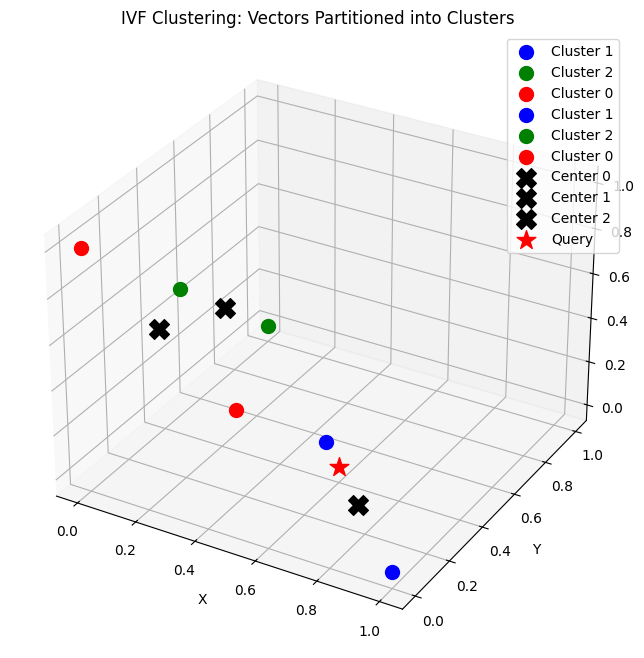

In [36]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Visualize IVF clustering
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Get cluster labels
vectors_array = np.array(vectors)
cluster_labels = ivf.kmeans.predict(vectors_array)

colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

# Plot vectors colored by cluster
for i, vec in enumerate(vectors):
    color = colors[cluster_labels[i] % len(colors)]
    ax.scatter(vec[0], vec[1], vec[2], color=color, s=100, label=f'Cluster {cluster_labels[i]}' if i == 0 or cluster_labels[i] != cluster_labels[i-1] else "")

# Plot cluster centers
for i, center in enumerate(ivf.kmeans.cluster_centers_):
    ax.scatter(center[0], center[1], center[2], color='black', s=200, marker='X', label=f'Center {i}')

# Plot query
ax.scatter(query[0], query[1], query[2], color='red', s=200, marker='*', label='Query')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('IVF Clustering: Vectors Partitioned into Clusters')
ax.legend()
plt.show()

In [37]:
# Demonstrate LSH (Locality Sensitive Hashing)
lsh = SimpleLSH(num_hash_tables=3, hash_size=4)  # 3 hash tables, 4-bit hashes
for vec in vectors:
    lsh.add_vector(vec)
lsh_results = lsh.search(query, k=3)
print("\nLSH Results:")
for idx, sim in lsh_results:
    print(f"Index: {idx}, Similarity: {sim:.3f}, Vector: {vectors[idx]}")



LSH Results:


Key differences between the approaches:
IVF: Fast search by limiting to relevant partitions (clusters), more deterministic
LSH: Probabilistic approach, may miss some similar items but very fast and memory efficient


## indexing.py
indexing.py
Explanation of Indexing
Indexing in vector databases refers to data structures that enable fast similarity search.
Without indexing, searching would require comparing the query to every vector (brute force).
Indexing algorithms organize vectors to reduce search time from O(n) to O(log n) or better.
Import required libraries for indexing demonstration
KDTree provides exact nearest neighbor search for low-dimensional data


In [38]:
from sklearn.neighbors import KDTree
# numpy for numerical operations and random vector generation
import numpy as np


In [39]:
# Generate sample vectors to demonstrate indexing
# Set random seed for reproducible results
np.random.seed(42)
# Create 100 random 2D vectors (points in 2D space)
vectors = np.random.rand(100, 2)  # 100 vectors in 2D


In [40]:
# Build KD-Tree index from the vectors
# KD-Tree partitions space into regions for efficient nearest neighbor search
kdtree = KDTree(vectors)


In [41]:
# Define query point for nearest neighbor search
# This represents a query vector we want to find similar vectors for
query = np.array([[0.5, 0.5]])


In [42]:
# Find k nearest neighbors using the KD-Tree index
# query() returns distances and indices of the k closest vectors
distances, indices = kdtree.query(query, k=5)


In [43]:
# Display the indexing results
print("KD-Tree Indexing Example:")
print(f"Query point: {query[0]}")
print("Nearest neighbors:")
# Iterate through the results and display each neighbor
for i, (dist, idx) in enumerate(zip(distances[0], indices[0])):
    print(f"{i+1}. Distance: {dist:.3f}, Vector: {vectors[idx]}")


KD-Tree Indexing Example:
Query point: [0.5 0.5]
Nearest neighbors:
1. Distance: 0.076, Vector: [0.52273283 0.42754102]
2. Distance: 0.110, Vector: [0.60956433 0.50267902]
3. Distance: 0.138, Vector: [0.63352971 0.53577468]
4. Distance: 0.186, Vector: [0.31435598 0.50857069]
5. Distance: 0.187, Vector: [0.36778313 0.63230583]


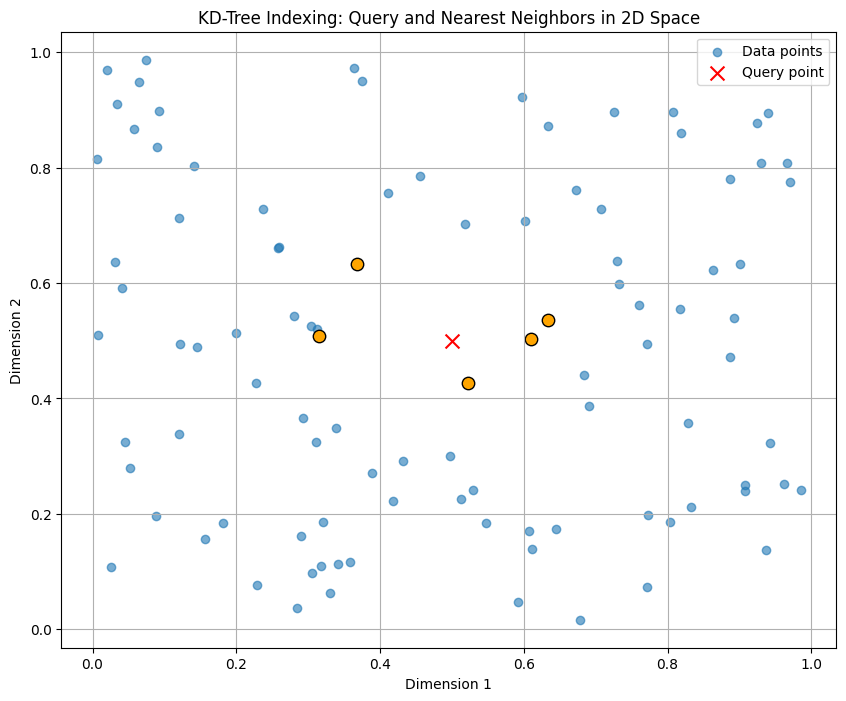

In [44]:
import matplotlib.pyplot as plt

# Visualize KD-Tree indexing: plot the 2D vectors and query
plt.figure(figsize=(10, 8))
plt.scatter(vectors[:, 0], vectors[:, 1], alpha=0.6, label='Data points')
plt.scatter(query[0, 0], query[0, 1], color='red', s=100, marker='x', label='Query point')

# Plot the nearest neighbors
for idx in indices[0]:
    plt.scatter(vectors[idx, 0], vectors[idx, 1], color='orange', s=80, edgecolor='black')

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('KD-Tree Indexing: Query and Nearest Neighbors in 2D Space')
plt.legend()
plt.grid(True)
plt.show()

Types of indexing algorithms used in vector databases:
- Exact indexing: KD-Tree, Ball-Tree (work well for low dimensions like 2D-20D)
- Approximate indexing: HNSW, IVF, LSH (optimized for high dimensions like 384D-1536D)
- Trade-off: Approximate methods sacrifice some accuracy for massive speed improvements


Important note about dimensionality:
In high-dimensional spaces (>100D), traditional tree structures become ineffective
This is known as the "curse of dimensionality" - distances become meaningless
Approximate methods like HNSW (Hierarchical Navigable Small World) are used instead


Key benefits of indexing for RAG systems:
- Faster search: Reduces time complexity from O(n) linear scan to O(log n) or better
- Scalability: Enables handling millions/billions of vectors efficiently
- Memory efficiency: Uses compressed representations and approximate structures
- Real-time performance: Essential for production RAG systems requiring low latency
